In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
import astra
astra.set_gpu_index((0, 1, 2, 3))

from AdversarialRegularizer import AdversarialRegulariser
from ut import unify_form
from networks import AlexNet_3D
from ellipsgen.generate_data_function import get_batch
import numpy as np
import ellipsgen.CCB_class as CT
import ellipsgen.phantom_class as ph
import matplotlib.pyplot as plt

BATCH_SIZE = 4
LOOPS = 2
IMG_SIZE = 128
STEPS = 100

In [2]:
# Parameter choices. Heuristic in the BWGAN paper: Choose GAMMA as average dual norm of clean image
# LMB should be bigger than product of norm times dual norm.

# For s=0.0, this implies GAMMA =1.0
# For s=1.0, have GAMMA = 10.0 as realisitc value
S = 0.0
LMB = 10.0
GAMMA = 1.0
CUTOFF = 20.0

saves_path = '/export/scratch1/home/voxels-gpu0/codesprint_learned_prior/AdvRegSaves/ell_noisy_' + str(IMG_SIZE)
regularizer = AdversarialRegulariser(saves_path, IMAGE_SIZE=(None, IMG_SIZE, IMG_SIZE, IMG_SIZE, 1), NETWORK=AlexNet_3D,
                                     s=S, cutoff=CUTOFF, lmb=LMB, gamma=GAMMA)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use keras.layers.conv3d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.average_pooling3d instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /export/scratch1/home/voxels-gpu0/codesprint_learned_prior/AdvRegSaves/ell_noisy_128/Data/model-100
Save restored


In [4]:
class Misfit:
    def __init__(self, reg: AdversarialRegulariser, data, reg_lambda=1):
        self._reg = reg
        self._data = data
        self._reg_lambda = reg_lambda
        
        self.precompute_data_gradient(data)
    
    def precompute_data_gradient(self, y):
        # In each gradient we need A*y, so lets just precompute it
        case = CT.CCB_CT(y)
        print(case)
        self._AT_y = case
    
    def __call__(self, x):
        self._x = x
        
        return self 
            
    def value(self):
        # compute ||Fx - d|| + lambda * R
        pass
    
    def gradient(self):
        # grad_data = 
        
        grad_reg = self._reg.evaluate(unify_form(self._x))
        print(grad_reg.shape)
        # grad_misfit = # call ASTRA
        
        return grad_reg

    
def plot(x):
    plt.figure()
    plt.imshow(x[int(x.shape[0]/2), ...])
    plt.colorbar()
    plt.show()
    
    
def generate_pair():
    num_angles = 360
    noise = ['Poisson', 2 ** 14] # Do not go below 2 ** 8, lower number in the 2nd argument means more noise
    num_vox = IMG_SIZE
    voxels = [num_vox, num_vox, num_vox]
    src_rad = 10
    det_rad = 0

    data_obj = ph.phantom(voxels, '22 Ellipses', num_angles, noise, src_rad, det_rad)
    gt =  data_obj.f

    case = CT.CCB_CT(data_obj)
    fdk = case.do_FDK()
        
    plt.figure()
    plt.imshow(gt[int(IMG_SIZE/2), ...])
    plt.show()

    plt.figure()
    plt.imshow(fdk[int(IMG_SIZE/2), ...])
    plt.show()

    return (gt, fdk)


def iterative_gradient_descent(x, misfit: Misfit, iters=10):    
    for i in range(iters):
        g = misfit(x).gradient()
    
        # update step
        alpha = 1. # we could do linesearch
        np.add(x, np.multiply(alpha, g, out=g), out=x)
        
        plot(x)
    
    return x

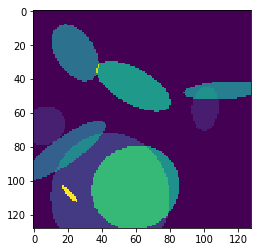

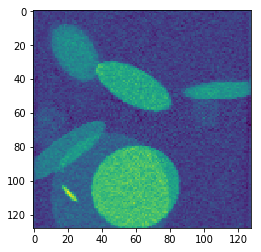

AttributeError: 'DiscreteLpElement' object has no attribute 'voxels'

In [5]:
# generate a noisy data pair
gt, fdk = generate_pair()

x = np.ones((IMG_SIZE, IMG_SIZE, IMG_SIZE))
obj = Misfit(regularizer, fdk)

iterative_gradient_descent(x, obj, iters=10)